# Final Project: Hate Speech Detection

### Dataset card for Measuring Hate Speech

This is a public release of the dataset described in Kennedy et al. (2020), consisting of 39,565 comments annotated by 7,912 annotators, for 135,556 combined rows. The primary outcome variable is the "hate speech score" but the 10 constituent labels (sentiment, (dis)respect, insult, humiliation, inferior status, violence, dehumanization, genocide, attack/defense, hate speech benchmark) can also be treated as outcomes. Includes 8 target identity groups (race/ethnicity, religion, national origin/citizenship, gender, sexual orientation, age, disability, political ideology) and 42 identity subgroups.

Original source: https://huggingface.co/datasets/ucberkeley-dlab/measuring-hate-speech#key-dataset-columns

What we're most interested in from the dataset are two columns: 

hatespeech - which is a score from 0 to 2, where higher = more hateful and lower = less hateful

text - lightly processed text of a social media post

We want to model hatespeech from text and see if we can detect it based on training data.

### Import Libraries and Dependencies

In [140]:
#import necessary libraries
import numpy as np
import pandas as pd
import nltk 
from nltk.corpus import stopwords
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('omw-1.4')
import re
import matplotlib.pyplot as plt
from wordcloud import WordCloud
plt.style.use('fivethirtyeight')
import pickle

[nltk_data] Downloading package wordnet to /Users/tonihe/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/tonihe/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/tonihe/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [141]:
import datasets 
dataset = datasets.load_dataset('ucberkeley-dlab/measuring-hate-speech', 'binary')   
df = dataset['train'].to_pandas()

Using custom data configuration ucberkeley-dlab--measuring-hate-speech-7cb9b0b8e4d0e1dd
Reusing dataset parquet (/Users/tonihe/.cache/huggingface/datasets/parquet/ucberkeley-dlab--measuring-hate-speech-7cb9b0b8e4d0e1dd/0.0.0/0b6d5799bb726b24ad7fc7be720c170d8e497f575d02d47537de9a5bac074901)


  0%|          | 0/1 [00:00<?, ?it/s]

In [142]:
# check our dataset
df.describe()

,comment_id,annotator_id,platform,sentiment,respect,insult,humiliate,status,dehumanize,violence,...,hatespeech,hate_speech_score,infitms,outfitms,annotator_severity,std_err,annotator_infitms,annotator_outfitms,hypothesis,annotator_age
count,135556.000000,135556.000000,135556.000000,135556.000000,135556.000000,135556.00000,135556.000000,135556.000000,135556.000000,135556.000000,...,135556.000000,135556.000000,135556.000000,135556.000000,135556.000000,135556.000000,135556.000000,135556.000000,135556.000000,135451.000000
mean,23530.416138,5567.097812,1.281352,2.954307,2.828875,2.56331,2.278638,2.698575,1.846211,1.052045,...,0.744733,-0.567428,1.034322,1.001052,-0.018817,0.300588,1.007158,1.011841,0.014589,37.910772
std,12387.194125,3230.508937,1.023542,1.231552,1.309548,1.38983,1.370876,0.898500,1.402372,1.345706,...,0.932260,2.380003,0.496867,0.791943,0.487261,0.236380,0.269876,0.675863,0.613006,11.641276
min,1.000000,1.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,...,0.000000,-8.340000,0.100000,0.070000,-1.820000,0.020000,0.390000,0.280000,-1.578693,18.000000
25%,18148.000000,2719.000000,0.000000,2.000000,2.000000,2.00000,1.000000,2.000000,1.000000,0.000000,...,0.000000,-2.330000,0.710000,0.560000,-0.380000,0.030000,0.810000,0.670000,-0.341008,29.000000
50%,20052.000000,5602.500000,1.000000,3.000000,3.000000,3.00000,3.000000,3.000000,2.000000,0.000000,...,0.000000,-0.340000,0.960000,0.830000,-0.020000,0.340000,0.970000,0.850000,0.110405,35.000000
75%,32038.250000,8363.000000,2.000000,4.000000,4.000000,4.00000,3.000000,3.000000,3.000000,2.000000,...,2.000000,1.410000,1.300000,1.220000,0.350000,0.420000,1.170000,1.130000,0.449555,45.000000
max,50070.000000,11142.000000,3.000000,4.000000,4.000000,4.00000,4.000000,4.000000,4.000000,4.000000,...,2.000000,6.300000,5.900000,9.000000,1.360000,1.900000,2.010000,9.000000,0.987511,81.000000


In [143]:
df.shape

(135556, 131)

In [144]:
# As we can see we have more columns / information than we need for this project
# We can just extract the information that we need by focusing on the hate_speech score

df.columns

Index(['comment_id', 'annotator_id', 'platform', 'sentiment', 'respect',
       'insult', 'humiliate', 'status', 'dehumanize', 'violence',
       ...
       'annotator_religion_hindu', 'annotator_religion_jewish',
       'annotator_religion_mormon', 'annotator_religion_muslim',
       'annotator_religion_nothing', 'annotator_religion_other',
       'annotator_sexuality_bisexual', 'annotator_sexuality_gay',
       'annotator_sexuality_straight', 'annotator_sexuality_other'],
      dtype='object', length=131)

## Data Exploration

We can now further explore our data to see what we're working with.

In [145]:
df_focus = df[['sentiment', 'hatespeech', 'hate_speech_score', 'text']]

In [146]:
df_focus['hatespeech'].unique()

array([0., 2., 1.])

<AxesSubplot:ylabel='hatespeech'>

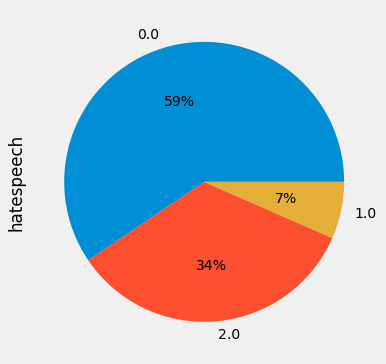

In [147]:
# We can see that hatespeech in this sample is 34% of the sample data, while 59% is not.

df_focus['hatespeech'].value_counts().plot(kind='pie', autopct='%1.0f%%', figsize=(11, 6))

<AxesSubplot:ylabel='sentiment'>

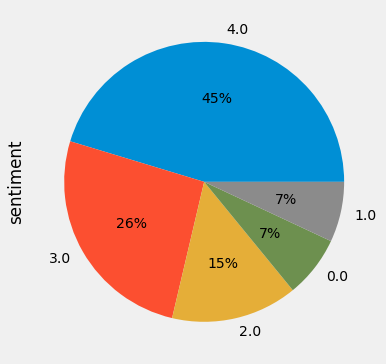

In [148]:
# Tweets are high in sentiments however it does not mean that they are hate speech.

df_focus['sentiment'].value_counts().plot(kind='pie', autopct='%1.0f%%', figsize=(11, 6))

In [149]:
df_focus

,sentiment,hatespeech,hate_speech_score,text
0,0.0,0.0,-3.90,Yes indeed. She sort of reminds me of the elde...
1,0.0,0.0,-6.52,The trans women reading this tweet right now i...
2,4.0,2.0,0.36,Question: These 4 broads who criticize America...
3,2.0,0.0,0.26,It is about time for all illegals to go back t...
4,4.0,2.0,1.54,For starters bend over the one in pink and kic...
...,...,...,...,...
135551,1.0,0.0,-4.88,عاجل سماحة #السيد_عبدالملك_بدرالدين_الحوثي نص...
135552,2.0,0.0,-4.40,Millions of #Yemen-is participated in mass ral...
135553,1.0,0.0,-2.49,@AbeShinzo @realDonaldTrump @shinzoabe 独裁者は行きま...
135554,2.0,0.0,-4.40,Millions of #Yemen-is participated in mass ral...


## Data Preprocessing

Before we can make use of our data, we'd need to preprocess the text, through NLP techniques such as stemming, lemmatization and removal of stopwords. Tokenization and vectorization are also techniques within NLP which will allow us to prep our data for further usage. 

In [150]:
#load the stopwords
stopword = stopwords.words('english')

In [151]:
#function to clean text
#we want to first unify the text to all lowercase
#remove all @, #, hyperlinks, puncuations, and non-alphanumeric characters
#lemmatize, here I used lemmatization rather than stemming to remove inflection / extract meaning


from nltk.stem import WordNetLemmatizer
lemma = WordNetLemmatizer()
def clean_txt(txt):
 txt = txt.lower()
 txt = re.sub("@[A-Za-z0-9_]+","", txt)
 txt = re.sub("#[A-Za-z0-9_]+","", txt)
 txt = re.sub(r"http\S+", "", txt)
 txt = re.sub(r"www.\S+", "", txt)
 txt = re.sub('[()!?]', ' ', txt)
 txt = re.sub('\[.*?\]',' ', txt)
 txt = re.sub("[^a-z0-9]"," ", txt)
 txt = lemma.lemmatize(txt)
 txt = txt.split()
 txt = [w for w in txt if not w in stopword]
 txt = " ".join(word for word in txt)
 return txt

In [152]:
df_focus['clean_txt'] = df_focus['text'].apply(clean_txt)

<ipython-input-152-3fc1c794e608>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_focus['clean_txt'] = df_focus['text'].apply(clean_txt)


In [269]:
#we can see that the new column called 'clean_txt' 
df_focus

,sentiment,hatespeech,hate_speech_score,text,clean_txt
0,0.0,0.0,-3.90,Yes indeed. She sort of reminds me of the elde...,yes indeed sort reminds elder lady played part...
1,0.0,0.0,-6.52,The trans women reading this tweet right now i...,trans women reading tweet right beautiful
2,4.0,2.0,0.36,Question: These 4 broads who criticize America...,question 4 broads criticize america country fl...
3,2.0,0.0,0.26,It is about time for all illegals to go back t...,time illegals go back country origin keep free...
4,4.0,2.0,1.54,For starters bend over the one in pink and kic...,starters bend one pink kick ass pussy get tast...
...,...,...,...,...,...
135551,1.0,0.0,-4.88,عاجل سماحة #السيد_عبدالملك_بدرالدين_الحوثي نص...,sayyed abdulmalik saudi regime learn 9th ramad...
135552,2.0,0.0,-4.40,Millions of #Yemen-is participated in mass ral...,millions participated mass rallies 13squares v...
135553,1.0,0.0,-2.49,@AbeShinzo @realDonaldTrump @shinzoabe 独裁者は行きま...,dictator goes people iran staying
135554,2.0,0.0,-4.40,Millions of #Yemen-is participated in mass ral...,millions participated mass rallies 13squares v...


In [270]:
# For the purposes of classification, we assume that hatespeech 1.0 is also hatespeech.
df_focus[df_focus['hatespeech'] == 1.0]

,sentiment,hatespeech,hate_speech_score,text,clean_txt


In [155]:
df_focus[df_focus['hatespeech'] == 1.0] = 2.0

<ipython-input-155-dd4fe74b2229>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_focus[df_focus['hatespeech'] == 1.0] = 2.0
/usr/local/lib/python3.8/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [156]:
df_focus['hatespeech'].unique()

array([0., 2.])

<AxesSubplot:ylabel='hatespeech'>

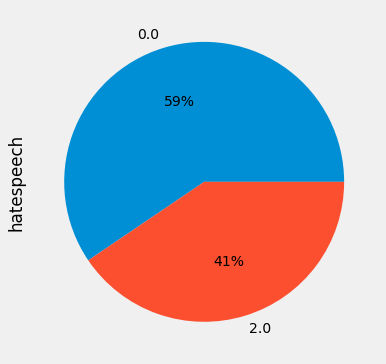

In [157]:
# I merged the 1.0 and 2.0 for hatespeech together to get that
# 59% of the data is considered not hatespeech 
# whereas 41% of the data is considered hatespeech
df_focus['hatespeech'].value_counts().plot(kind='pie', autopct='%1.0f%%', figsize=(11, 6))

### Preparing for Supervised Learning:

Now that we have the data cleaned, because we'll be conducting supervised machine learning. We want to further extract the features and labels from the data. 

ML models learn from 'features' or input data to then try to predict unseen 'test' data. The goal is to classify or correctly label input into categories ie: classification. 

In this case, our input would be the clean_txt column which we've just added to our dataframe and our labels would be hatespeech which is a score given from 0 which is not hateful to 2 which is hateful. 

In [216]:
#To analyze a preprocessed data, it needs to be converted into features.
#features and labels for machine learning

features = df_focus.iloc[:,4].values
labels = df_focus.iloc[:, 1].values

In [217]:
features

array(['yes indeed sort reminds elder lady played part movie titanic telling story wanted cover really would proud proud race matter',
       'trans women reading tweet right beautiful',
       'question 4 broads criticize america country flee get want make america like former hell hole think let explain gratitude letting country',
       ..., 'dictator goes people iran staying',
       'millions participated mass rallies 13squares various governorates mark international day al quds url',
       'op really hope commit suicide one day die ass cancer feel sorry justify action fault leaving country fight afghanistan poor boys defending country foreign invaders'],
      dtype=object)

In [218]:
labels

array([0., 0., 2., ..., 0., 0., 2.])

Now we'll need to turn raw features into TF-IDF features. 

TF-IDF (Term frequency-inverse document frequency) is a technique which calculates the importance of a term within a document given its frequency of occurrence. We set the maximum number of features to 2000 and with minimum ocurrence of 5 occurring in maximum of less than 80% of the document. We want to ignore words that are too rare and also too frequent.

In [281]:
#In order to do so we want to put 'clean_txt' into a workable list

processed_features = []

for sentence in range(0, len(features)):
    # remove all the special characters
    processed_feature = re.sub(r'\W', ' ', str(features[sentence]))

    # remove all single characters
    processed_feature= re.sub(r'\s+[a-zA-Z]\s+', ' ', processed_feature)
    
    processed_features.append(processed_feature)

In [282]:
processed_features

['yes indeed sort reminds elder lady played part movie titanic telling story wanted cover really would proud proud race matter',
 'trans women reading tweet right beautiful',
 'question 4 broads criticize america country flee get want make america like former hell hole think let explain gratitude letting country',
 'time illegals go back country origin keep freeway open prevent heavy traffic',
 'starters bend one pink kick ass pussy get taste begging dick inside',
 'sounds like kinda wholsesome life die never met black lesbians guess first ever',
 'fuck insignificant simple minded redneck gets vagina decide wants',
 'fuck insufferable retarded faggot',
 'omg ego young young inexperienced women display remarkable self absorbed proud mistakes constituents made giving bit power quite surprised find vast majority americans think women represent worst modern america egos control',
 'worthless whore tits look nice bite marks cum',
 '9 uhhhh like lgbt lot feel proud done help others community

In [283]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=2000, min_df=5, max_df=0.8)
processed_features = vectorizer.fit_transform(processed_features).toarray()

In [284]:
#as we can see processed features are vectorized into 0s and 1s. 

processed_features

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

# Algorithms Explored:

### Logistic Regression 

A generalized linear algorithm used to predict categorical probability of a class or event. Logistic regression is often used in categorical classification problems. In our case, the goal is simple, we've split our samples into hatespeech or not hatespeech. Logistic regression model will help us calculate the probability of a piece of text belonging in a category. We can use logistical regression as a rudimentary way to figure out whether or not a piece of text is hatespeech.


### Random Forest 

A collective of decision trees is called a Random Forest. To classify a new object based on its attributes, each tree is classified, and the tree “votes” for that class. The forest chooses the classification having the most votes (over all the trees in the forest). The main limitation of random forest is that a large number of trees can make the algorithm too slow and ineffective for real-time predictions.


### Naive Bayes 

Naive Bayes algorithm applies Bayes theorem to solve problems and 'naively' assumes that features are independent of eachother. Naive Bayes is commonly used in NLP as it can classify text with speed and decent accuracy. In our case, Multinomial Naïve Bayes considers the frequency in which a feature vector appears and makes assumptions accordingly. The algorithm can process large amounts of data in shorter amount of time compared to other methods. 


### Support Vector Machine 

Is a supervised machine learning algorithm that uses linear model for classification and regression problems. The algorithm creates either a line or hyperplane to classify data into respective classes. In our case, we're using Linear Support Vector classifier, which is fast and efficient in returning our results. 

In [227]:
%time

#split data into train and test with a 70% train and 30% test.

from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(processed_features, labels, test_size=0.3, random_state=0)


CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.96 µs


In [228]:
%time

# Logistic Regression
from sklearn.linear_model import LogisticRegression 

model = LogisticRegression(solver='lbfgs', max_iter=1000).fit(X_train, y_train)
predicted_classes = model.predict(X_test)

CPU times: user 4 µs, sys: 1e+03 ns, total: 5 µs
Wall time: 8.11 µs


In [230]:
%time

logistic_report = classification_report(y_test, predicted_classes)

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 7.87 µs


In [231]:
print(logistic_report)

              precision    recall  f1-score   support

         0.0       0.85      0.87      0.86     24104
         2.0       0.80      0.77      0.79     16563

    accuracy                           0.83     40667
   macro avg       0.82      0.82      0.82     40667
weighted avg       0.83      0.83      0.83     40667



In [232]:
%time
#RandomForest Model

from sklearn.ensemble import RandomForestClassifier

text_classifier = RandomForestClassifier(n_estimators=200, random_state=0)
rf_model = text_classifier.fit(X_train, y_train)
rf_predictions = rf_model.predict(X_test)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.05 µs


In [233]:
%time
rf_report = classification_report(y_test, rf_predictions)

CPU times: user 4 µs, sys: 1e+03 ns, total: 5 µs
Wall time: 8.82 µs


In [234]:
print(rf_report)

              precision    recall  f1-score   support

         0.0       0.85      0.87      0.86     24104
         2.0       0.80      0.79      0.79     16563

    accuracy                           0.83     40667
   macro avg       0.83      0.83      0.83     40667
weighted avg       0.83      0.83      0.83     40667



In [235]:
%time

#Naive Bayes Model

from sklearn.naive_bayes import MultinomialNB
multiNB = MultinomialNB().fit(X_train, y_train)
nb_predictions = multiNB.predict(X_test)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.77 µs


In [236]:
%time

nb_report = classification_report(y_test, nb_predictions)

CPU times: user 4 µs, sys: 1e+03 ns, total: 5 µs
Wall time: 9.06 µs


In [237]:
print(nb_report)

              precision    recall  f1-score   support

         0.0       0.75      0.88      0.81     24104
         2.0       0.77      0.58      0.66     16563

    accuracy                           0.76     40667
   macro avg       0.76      0.73      0.73     40667
weighted avg       0.76      0.76      0.75     40667



In [267]:
from sklearn.svm import LinearSVC

model = LinearSVC().fit(X_train, y_train)
predicted_classes = model.predict(X_test)
svm_report = classification_report(y_test, predicted_classes)

In [268]:
print(svm_report)

              precision    recall  f1-score   support

         0.0       0.85      0.86      0.86     24104
         2.0       0.79      0.78      0.78     16563

    accuracy                           0.83     40667
   macro avg       0.82      0.82      0.82     40667
weighted avg       0.83      0.83      0.83     40667



In [238]:
pickle.dump(vectorizer, open("vectorizer.pickle", "wb")) ## Save vectorizer
pickle.load(open("vectorizer.pickle", 'rb'))     ## Load vectorizer

TfidfVectorizer(max_df=0.8, max_features=2000, min_df=5)